# Figures of spatial variation in continental vs. glacial river contributions 

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from matplotlib.colors import ListedColormap
import xarray as xr
import warnings
from scipy.interpolate import interp1d
warnings.filterwarnings('ignore')

%matplotlib inline

##### Parameters:

In [2]:
# Domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799
isize = imax - imin
jsize = jmax - jmin

month = 8

# Results folders:
folder_ref  = '/data/brogalla/run_storage/Mn-reference-202110/'
folder_glac = '/data/brogalla/run_storage/river-glacial-202112/'
folder_cont = '/data/brogalla/run_storage/river-continental-202112/'

land_color = '#a9a7a2'

# Color map:
N = 256
vals_cont = np.ones((N, 4))
vals_cont[:, 0] = np.linspace(171/N, 1, N)
vals_cont[:, 1] = np.linspace(92/N, 1, N)
vals_cont[:, 2] = np.linspace(41/N, 1, N)
cont_cmap = ListedColormap(vals_cont).reversed()

vals_glac = np.ones((N, 4))
vals_glac[:, 0] = np.linspace(8/N, 1, N)
vals_glac[:, 1] = np.linspace(115/N, 1, N)
vals_glac[:, 2] = np.linspace(180/N, 1, N)
glac_cmap = ListedColormap(vals_glac).reversed()

vals_both = np.ones((N, 4))
vals_both[:, 0] = np.linspace(89/N, 1, N); 
vals_both[:, 1] = np.linspace(89/N, 1, N)
vals_both[:, 2] = np.linspace(89/N, 1, N)
both_cmap = ListedColormap(vals_both).reversed()

##### Load files:

In [3]:
# Meshmasks
mask          = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask         = np.array(mask.variables['tmask'])
land_mask     = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 
tmask_full    = np.empty((12,50,isize,jsize))
tmask_full[:] = tmask[0,:,imin:imax,jmin:jmax]
lon_ANHA12    = np.array(mask.variables['nav_lon'])
lat_ANHA12    = np.array(mask.variables['nav_lat'])
e3t           = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e1t_base      = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base      = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
hdept         = np.array(mask.variables['hdept'])[0,imin:imax,jmin:jmax]

In [4]:
ref     = nc.Dataset('/data/brogalla/run_storage/Mn-reference-202110/ANHA12_ref-2002_20211012/ANHA12_EXH006_2002_monthly.nc','r')
lon_sub = np.array(ref.variables['nav_lon'])
lat_sub = np.array(ref.variables['nav_lat'])
depth   = np.array(ref.variables['deptht'])

##### Functions:

In [78]:
def load_results():
    
    file = f'climatology.nc'
    path_ref  = f'{folder_ref}/{file}'
    path_glac = f'{folder_glac}/{file}'
    path_cont = f'{folder_cont}/{file}'
    
    with xr.open_dataset(f'{path_ref}') as monthly_ref:
        dmn_ref = monthly_ref['dissolmn'].values[:,0,:,:,:]
    
    with xr.open_dataset(f'{path_glac}') as monthly_glac:
        dmn_glac = monthly_glac['dissolmn'].values[:,0,:,:,:]
        
    with xr.open_dataset(f'{path_cont}') as monthly_cont:
        dmn_cont = monthly_cont['dissolmn'].values[:,0,:,:,:]
    
    return dmn_ref, dmn_glac, dmn_cont

Calculate the proportional contribution of glacial rivers to each grid cell:

$$ prop = \frac{Mn_{glacier}-Mn_{base}}{Mn_{base}} = \frac{Mn_{glacier}}{Mn_{base}} - 1 $$

In [79]:
def calculate_prop(dmn_riv_off, dmn_riv_on):
    # Input arguments:
    # - dmn_riv_on (t,z,y,x) --- concentration of dMn with riverine contribution on
    # - dmn_riv_off(t,z,y,x) --- concentration of dMn with rivers off
    
    # Contribution of rivers / total concentration (with rivers on):
    # should be an elementwise operation
    prop_river  = np.divide(dmn_riv_on - dmn_riv_off, dmn_riv_off)*100*2 # times two so that 100% 
    
    # Output:
    # - prop_river(t,z,y,x)  --- proportional contribution of river to observed [dMn]
    return prop_river

In [102]:
def calculate_cumulative(dmn_riv_off, dmn_riv_on):
    # Input arguments:
    # - dmn_riv_on (t,z,y,x) --- concentration of dMn with riverine contribution on
    # - dmn_riv_off(t,z,y,x) --- concentration of dMn with rivers off
    
    # Contribution of rivers / total concentration (with rivers on):
    # should be an elementwise operation
    river_on  = np.cumsum(dmn_riv_on,  axis=0)
    river_off = np.cumsum(dmn_riv_off, axis=0)
    
#     river_add  = (river_on-river_off)*1e9
    
    # Look at riverine increase relative to pre-existing amount
    river_add = (river_on/river_off)
    
    # Output:
    # - prop_river(t,z,y,x)  --- proportional contribution of river to observed [dMn]
    return river_add

##### Calculations:

In [103]:
dmn_ref, dmn_glac, dmn_cont = load_results()
glacier_prop                = calculate_prop(dmn_ref, dmn_glac)
seasonal_glacier_add        = calculate_cumulative(dmn_ref, dmn_glac)

In [104]:
depths_for_prop = np.tile(e3t, (12,1,1,1))

# Depth-weighted proportion:
index_bottom = 17
depth_bottom = np.copy(hdept) # sum from surface to sea floor
depth_bottom[depth_bottom > depth[index_bottom]] = depth[index_bottom] # sum over depth from surface to index bottom
depth_bottom[depth_bottom == 0] = np.nan # where ocean depth is zero, replace depth with NaN

seasonal_depth_glac = np.nansum(seasonal_glacier_add[:,0:index_bottom,:,:]*depths_for_prop[:,0:index_bottom,:,:], axis=1)
depth_sum_glac      = np.nansum(glacier_prop[:,0:index_bottom,:,:]*depths_for_prop[:,0:index_bottom,:,:], axis=1)
depth_sum_cont      = np.nansum(continental_prop[:,0:index_bottom,:,:]*depths_for_prop[:,0:index_bottom,:,:], axis=1)
seasonal_weighted_glac = seasonal_depth_glac/depth_bottom
depth_weighted_glac    = depth_sum_glac/depth_bottom
depth_weighted_cont    = depth_sum_cont/depth_bottom

# Mask small values:
ma_glac = np.ma.masked_where((depth_weighted_glac < 0.5), depth_weighted_glac)

### Figures

In [71]:
NOW_lons = np.array([-79, -75, -70, -67, -67, -70, -72.8, -75, -78, -78.5, -79.2, -79])
NOW_lats = np.array([74.6, 75.2, 75.4, 75.8, 76, 76, 78.2, 78.2, 76.5, 75.5, 74.8, 74.6])

t = np.arange(len(NOW_lons))
ti = np.linspace(0, t.max(), 10 * t.size)

xi = interp1d(t, NOW_lons, kind='cubic')(ti)
yi = interp1d(t, NOW_lats, kind='cubic')(ti)

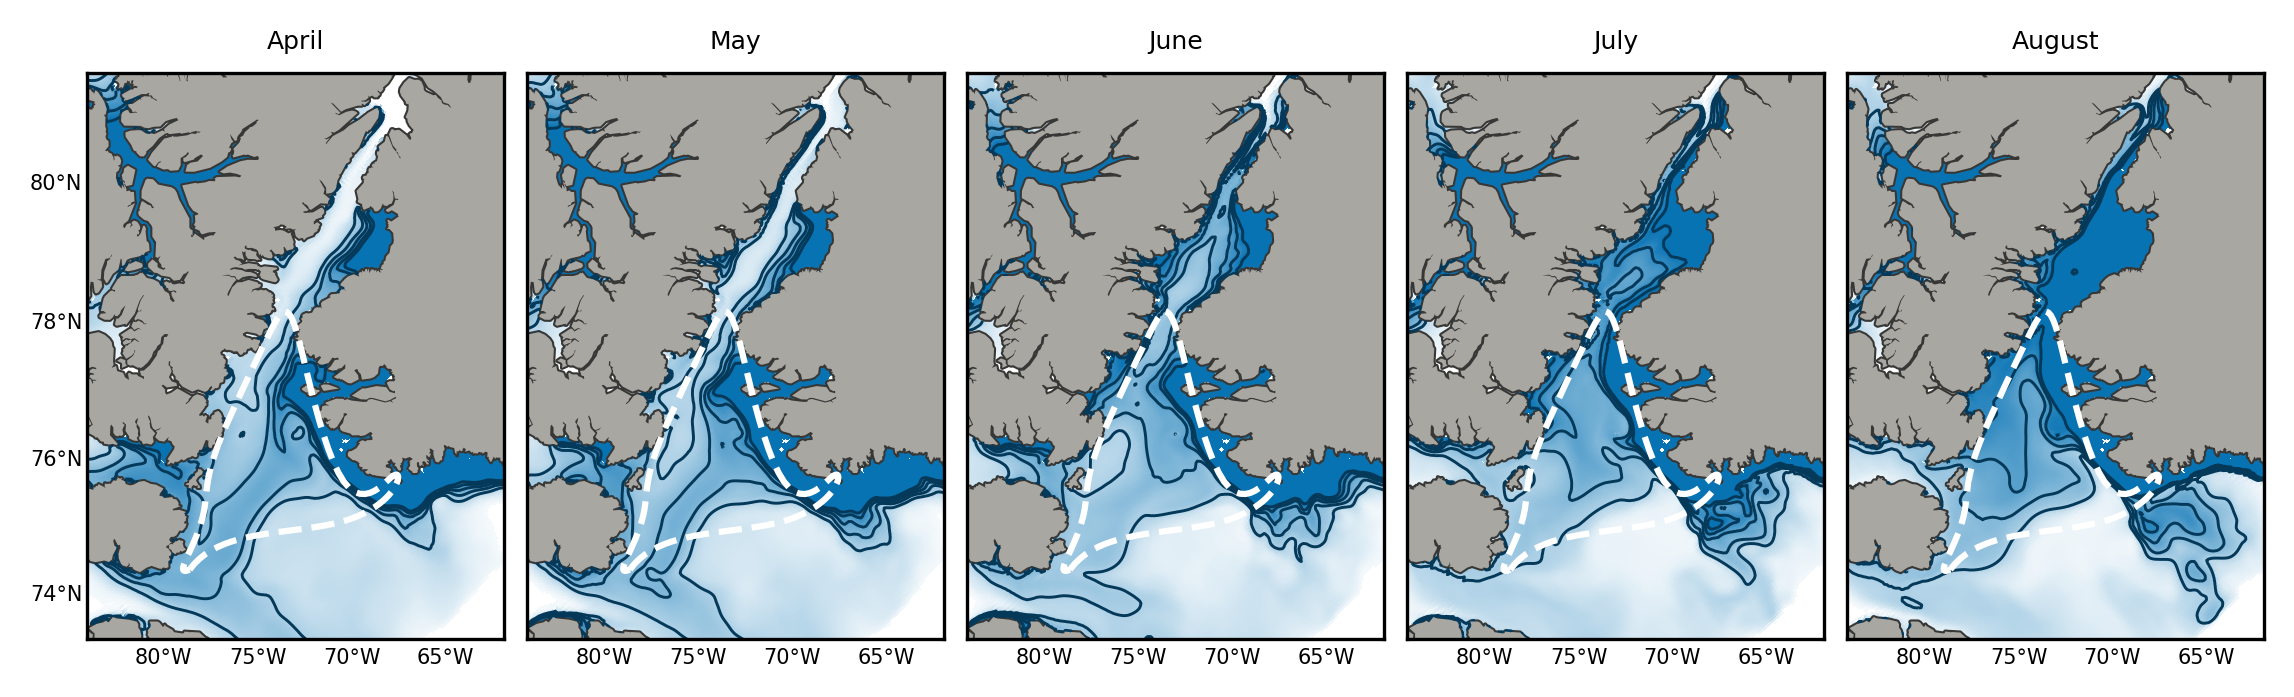

In [72]:
fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/polynya.pickle','rb'))

months_ind = [3,4,5,6,7]
months     = ['April', 'May', 'June', 'July', 'August']

x_land, y_land   = proj1(lon_ANHA12, lat_ANHA12)
x_model, y_model = proj1(lon_sub, lat_sub)

x_NOW, y_NOW = proj1(NOW_lons, NOW_lats)
x_NOW2, y_NOW2 = proj1(xi, yi)

# loop over each of the panels
for i, axis in enumerate(ax.ravel()):
    # Coloured contours:
    CS1 = axis.pcolormesh(x_model, y_model, ma_glac[months_ind[i],:,:], vmin=0, vmax=12, cmap=glac_cmap)
    
    # Contour lines:
    glac = axis.contour(x_model, y_model, ma_glac[months_ind[i],:,:], \
                      levels=[4,6,8,10,12], vmin=vmin_cglac, vmax=vmax_glac, colors='#04395a', linewidths=0.7)
    
    axis.plot(x_NOW2, y_NOW2, '--w', linewidth=1.5, zorder=3)
#     ax.clabel(glac, [2, 6, 10], inline=1, fontsize=4, fmt='%1.f')
    axis.set_title(months[i], fontsize=6)

# Colorbars:
# cbaxes1 = fig.add_axes([0.07, 0.53, 0.02, 0.14]) 
# CBar1   = plt.colorbar(CS1, ax=ax[0], cax=cbaxes1, ticks=np.arange(0,16,2), drawedges=True)  
# CBar1.ax.tick_params(axis='y', length=0, labelsize=5)


# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/D2-NOW-climatology.png', bbox_inches='tight', dpi=300)

In [108]:
for i in range(0,12,1):
    print(np.nanmax(seasonal_weighted_glac[i,:,:]))

7.034624
15.059979
23.165264
32.22258
43.51606
57.019085
70.04145
79.46225
86.729355
91.38569
96.37071
102.13559


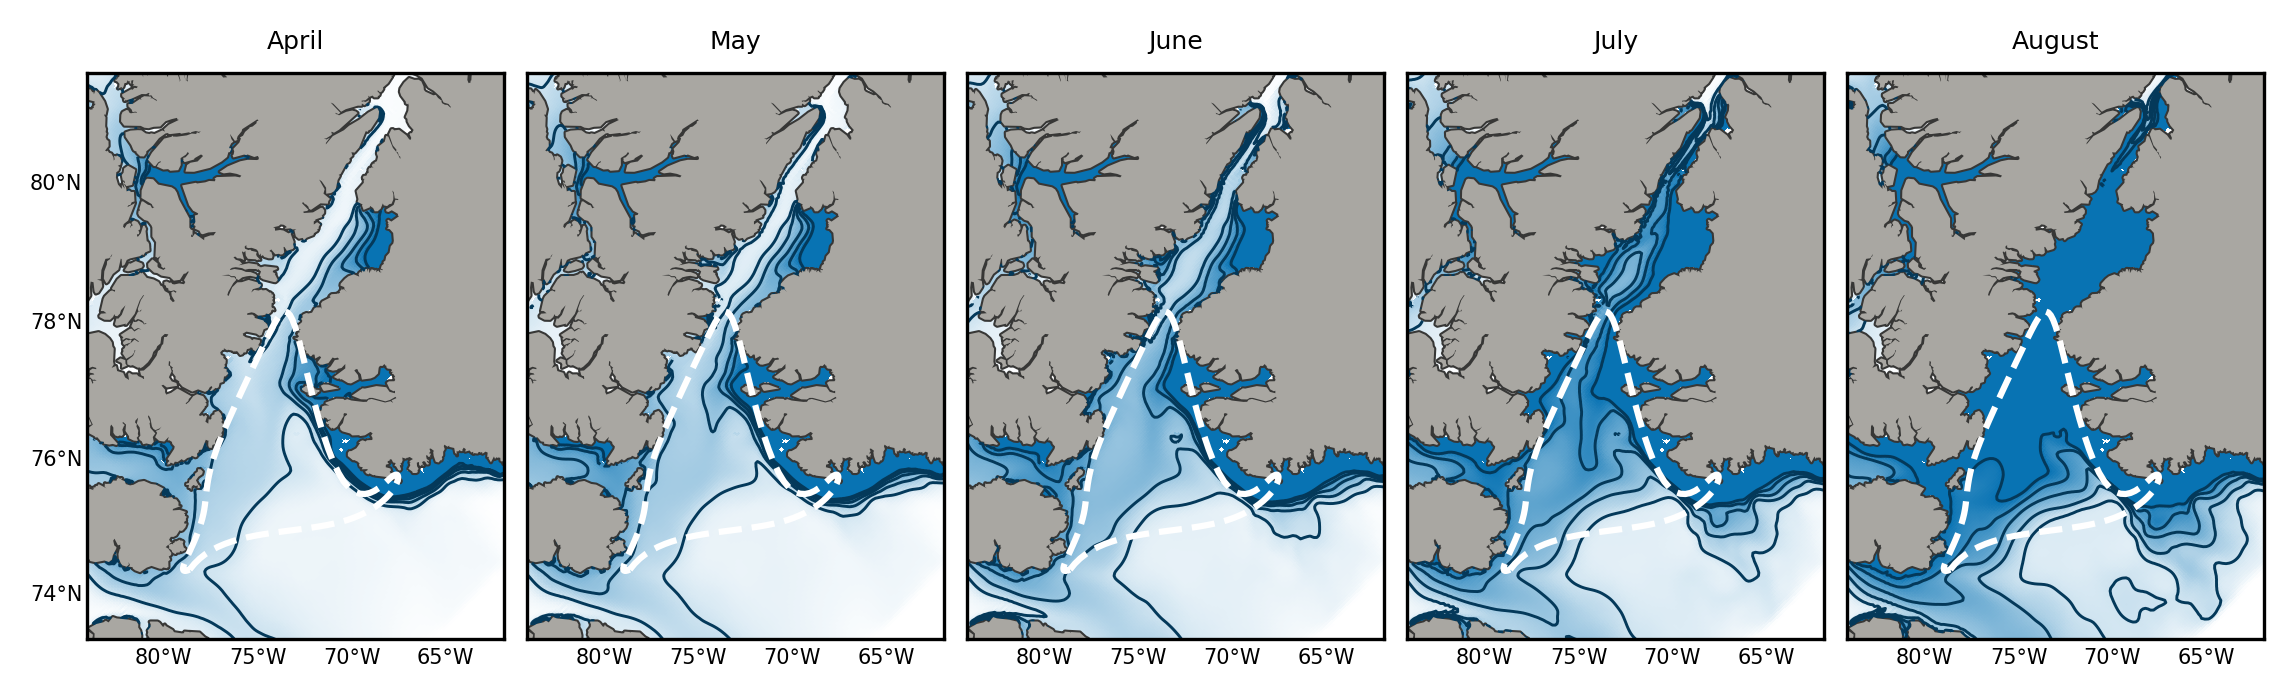

In [113]:
fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/polynya.pickle','rb'))

months_ind = [3,4,5,6,7]
months     = ['April', 'May', 'June', 'July', 'August']

x_land, y_land   = proj1(lon_ANHA12, lat_ANHA12)
x_model, y_model = proj1(lon_sub, lat_sub)

x_NOW, y_NOW = proj1(NOW_lons, NOW_lats)
x_NOW2, y_NOW2 = proj1(xi, yi)

# loop over each of the panels
for i, axis in enumerate(ax.ravel()):
    # Coloured contours:
    CS1 = axis.pcolormesh(x_model, y_model, seasonal_weighted_glac[months_ind[i],:,:], vmin=0, vmax=0.5, cmap=glac_cmap)
    
    # Contour lines:
    glac = axis.contour(x_model, y_model, seasonal_weighted_glac[months_ind[i],:,:], \
                      levels=[0.1,0.2,0.3,0.4,0.5], vmin=vmin_cglac, vmax=vmax_glac, colors='#04395a', linewidths=0.7)
    
    axis.plot(x_NOW2, y_NOW2, '--w', linewidth=1.5, zorder=3)
#     ax.clabel(glac, [2, 6, 10], inline=1, fontsize=4, fmt='%1.f')
    axis.set_title(months[i], fontsize=6)

# Colorbars:
# cbaxes1 = fig.add_axes([0.07, 0.53, 0.02, 0.14]) 
# CBar1   = plt.colorbar(CS1, ax=ax[0], cax=cbaxes1, ticks=np.arange(0,16,2), drawedges=True)  
# CBar1.ax.tick_params(axis='y', length=0, labelsize=5)


# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/D2-NOW-climatology.png', bbox_inches='tight', dpi=300)